# Baseline model overview

Create a simple baseline model to compare more advanced methods against.

### Ideas based on EDA

**Using only categorical variables for prediction:**
- Take one variable and calculate the average salary per category
- Take a combination of 2 or more variables and calculate the average salary per each multi-variable grouping

Predictions with categorical variables will be made by joining the calculated averages to the prediction data using the group of variables as the key.

**Incorporating the numerical variables for prediction:**

The baseline model will require at least one categorical variable and models using just a numerical variable for prediction will not be tested. To illustrate why this decision was made, consider taking the average salary of all jobs within 1 `milesFromMetropolis`. There will be a mixture of all different kinds of `jobTypes` and will likely not give a good estimate, since the average salary would be taking into account roles ranging from `JANITOR` to `CEO`.

Instead, the numerical variables will be used as an additive value to the average salary that was calculated with the categorical variable(s).

*Steps for predictions using numerical variables:*
1. The variables `yearsExperience` and `milesFromMetropolis` will be grouped by their values and the average salary will be calculated.
2. The overall average salary will be subtracted from the grouped averages. This gives values that are relative to the average salary
3. These values will be added to the average salary calculated from the categorical variables.  
*Note*: If both numerical variables are used, then there might be issues with adding all the numbers together. 


___

In [1]:
import pandas as pd
from itertools import combinations

from src.eda_utils import salary_per_category_table
from src.Baseline import BaselineModel, TestModels

# Load data

In [2]:
train_salaries = pd.read_csv("../data/interim/salaries_train_85_15_split.csv", index_col = 0)
test_salaries = pd.read_csv("../data/interim/salaries_test_85_15_split.csv", index_col = 0)

In [3]:
print(f"training set shape: {train_salaries.shape}")
print(f"test set shape: {test_salaries.shape}")

training set shape: (850000, 8)
test set shape: (150000, 8)


## Illustrating what the baseline model is doing

#### All combinations of categorical variables

In [4]:
category_vars = ['jobType', 'degree', 'major', 'industry']

category_combos = []
for i in range(1,5):
    combos = combinations(category_vars, i)
    for j in combos:
        category_combos.append(list(j))

category_combos

[['jobType'],
 ['degree'],
 ['major'],
 ['industry'],
 ['jobType', 'degree'],
 ['jobType', 'major'],
 ['jobType', 'industry'],
 ['degree', 'major'],
 ['degree', 'industry'],
 ['major', 'industry'],
 ['jobType', 'degree', 'major'],
 ['jobType', 'degree', 'industry'],
 ['jobType', 'major', 'industry'],
 ['degree', 'major', 'industry'],
 ['jobType', 'degree', 'major', 'industry']]

In [5]:
len(category_combos)

15

# `BaselineModel` Class

*Params*
- constructor:
    + grouping_vars: list of categorical variables to group on for fitting
    + numeric_vars:  list of numerical variables to fit 
    
*Methods*
- fit():
    + For the grouping variables, this calculates the average salary per group and stores this values with each grouping variable as an index
    + For the numeric variables, this groups by each value and calculates the mean and stores it with each value of the variable as the index and the average as the value

#### Evaluate function

#### data output of the loop

for each category combo, turn it into the index  
columns measuring MSE for: just categories, years, miles, both, both with mean, both with sum 

#### find_best() function prototype

### insights from best baseline model

in each of the combinations where `jobType` is missing, the MSE is higher than combinations where it is

Interestingly, `industry` when used as a single categorical variable predictor is the worst among any other single categorical predictor. But when it is combined with `jobType` then the two variables together are the best among all two-category combinations



Best model score: 373.26226508349805

Best model parameters:
{'category_vars': ['jobType', 'degree', 'major', 'industry'], 'numeric_vars': ['yearsExperience', 'milesFromMetropolis'], 'numeric_combo': 'sum'}





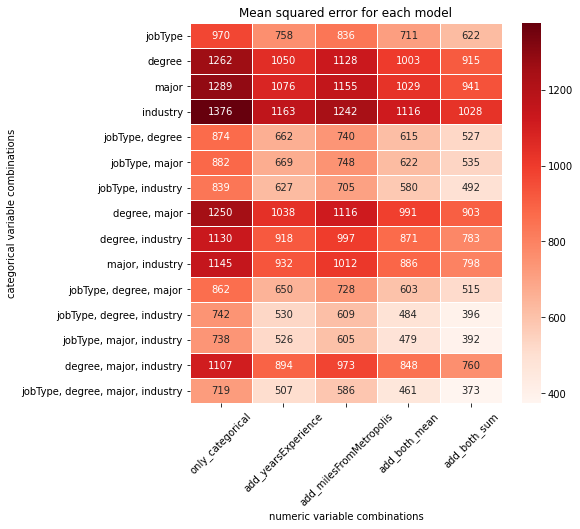

In [6]:
test = TestModels(train_salaries, test_salaries, category_combos)

In [7]:
test.df_output

,only_categorical,add_yearsExperience,add_milesFromMetropolis,add_both_mean,add_both_sum
jobType,970.339894,757.845939,835.945286,710.830971,622.451475
degree,1262.336448,1049.941439,1127.962300,1002.887229,914.567436
major,1288.942168,1075.819089,1155.102219,1029.396013,940.979284
industry,1376.210472,1162.751731,1242.291772,1116.457111,1027.833176
"jobType, degree",873.828005,661.975171,739.758036,614.801962,526.905347
"jobType, major",881.622029,669.262451,747.865518,622.499344,534.506085
"jobType, industry",839.131042,626.756967,705.366412,579.997049,491.992482
"degree, major",1250.085581,1037.621574,1116.118072,990.805182,902.654209
"degree, industry",1130.474565,918.162213,996.770889,871.401910,783.458682
"major, industry",1145.100338,932.045073,1011.902215,885.909003,797.847095
